In [1]:
%cd ..

/sunjinsheng/codebase/cv_codeformer


In [10]:
import os
import cv2
import argparse
import glob
import torch
from PIL import Image
from torchvision.transforms.functional import normalize
from torchvision import transforms

from src.utils import imwrite, img2tensor, tensor2img
from src.utils.download_util import load_file_from_url
from src.utils.misc import get_device
from src.archs import * # !register architectures
from src.utils.options import dict2str
from src.utils.registry import ARCH_REGISTRY


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ set up CodeFormer restorer -------------------
net = ARCH_REGISTRY.get('CodeFormer')(
    dim_embd=512,
    codebook_size=512,
    n_head=8,
    n_layers=9,
    connect_list=['32', '64', '128']
).to(device)

In [4]:
ckpt_path = 'weights/codeformer/stage3/codeformer_inpainting.pth'
checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=True)['params_ema']
net.load_state_dict(checkpoint)
net.eval()
# print(net.state_dict().keys())
set([key.split('.')[0] for key in list(net.state_dict().keys())])

{'encoder',
 'feat_emb',
 'ft_layers',
 'fuse_convs_dict',
 'generator',
 'idx_pred_layer',
 'position_emb',
 'quantize'}

Processing: a0002.jpg


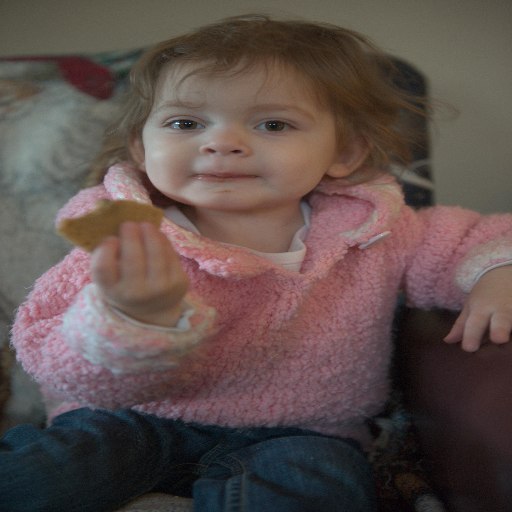

In [22]:
# -------------------- start to processing ---------------------
suffix = '.jpg'
result_root = 'results'
img_path = '/root/wp/data/iharmony4/HAdobe5k/real_images/a0002.jpg'


img_name = os.path.basename(img_path)
basename, ext = os.path.splitext(img_name)
print(f'Processing: {img_name}')
input_face = cv2.imread(img_path)
input_face = cv2.cvtColor(input_face, cv2.COLOR_BGR2RGB)
input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
assert input_face.shape[:2] == (512, 512), 'Input resolution must be 512x512 for inpainting.'
Image.fromarray(input_face)

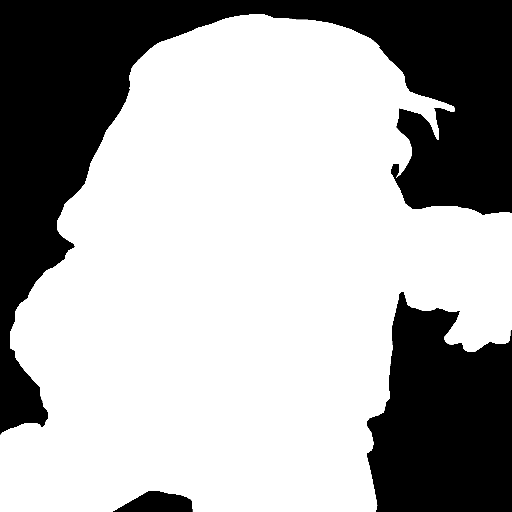

In [23]:
mask_path = "/root/wp/data/iharmony4/HAdobe5k/masks/a0002_1.png"
mask = cv2.imread(mask_path, 0)
mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_LINEAR)
Image.fromarray(mask)

In [24]:
# input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
input_face = img2tensor(input_face / 255., bgr2rgb=True, float32=True)
normalize(input_face, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
input_face = input_face.unsqueeze(0).to(device)
tf = transforms.Compose([
    transforms.ToTensor(),
])
mask = tf(mask)

In [25]:
with torch.no_grad():
    mask = mask.view(1, 1, 512, 512).to(device)
    # w is fixed to 1, adain=False for inpainting
    output_face = net(input_face, w=1, adain=False)[0]
    output_face = (1-mask)*input_face + mask*output_face
    save_face = tensor2img(output_face, rgb2bgr=True, min_max=(-1, 1))

del output_face
torch.cuda.empty_cache()

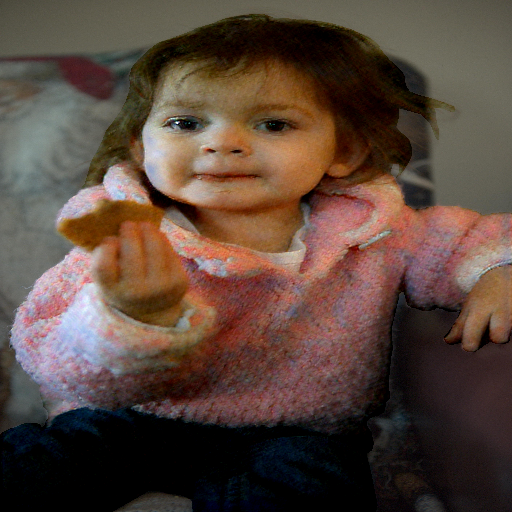

In [26]:
save_face = save_face.astype('uint8')
Image.fromarray(save_face)